# Import

In [42]:
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline as make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import plot_tree
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, make_scorer
from xgboost import XGBClassifier
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [43]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/iter-5/housing-classification-iter5.csv')

Remember to scale for a distance algorithm

# Split Data

In [44]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First obersvations: Need to replace missing values and scale. Use two pipes and column transformer.

# Prepare & Pipeline

In [46]:
categoric_features = list(X_train.select_dtypes(include=["object"]))
numeric_features = list(X_train.select_dtypes(exclude=["object"]))

In [47]:
numeric_pipe = make_pipeline(
    SimpleImputer()
)
categoric_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
)

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe_onehot", categoric_pipe, categoric_features),
    ]
)

In [49]:
# Instantiate the XGBoost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Create the pipeline
model_pipeline = make_pipeline(preprocessor, xgb_clf)

# Fit Model

In [50]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF', 'ScreenPorch',
                                                   'MSSubClass', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'Bsmt...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [54]:
print(model_pipeline.steps)

[('columntransformer', ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['LotArea', 'LotFrontage', 'TotalBsmtSF',
                                  'BedroomAbvGr', 'Fireplaces', 'PoolArea',
                                  'GarageCars', 'WoodDeckSF', 'ScreenPorch',
                                  'MSSubClass', 'OverallQual', 'OverallCond',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  '1stFlrSF', '2ndFl...
                                ('cat_pipe_onehot',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
   

In [55]:
feature_importances = model_pipeline.named_steps['xgbclassifier'].feature_importances_

feature_importances

array([0.01536681, 0.02435857, 0.01969932, 0.0273337 , 0.03012565,
       0.        , 0.02265116, 0.01239209, 0.01083096, 0.00305708,
       0.3444801 , 0.01339078, 0.01665102, 0.01204068, 0.01109307,
       0.02335853, 0.01670832, 0.01085913, 0.01898186, 0.01762887,
       0.        , 0.0494133 , 0.        , 0.        , 0.00682718,
       0.01459952, 0.        , 0.00977368, 0.00868312, 0.01089798,
       0.01083325, 0.        , 0.        , 0.        , 0.00771017,
       0.00873111, 0.00823248, 0.        , 0.00474091, 0.        ,
       0.        , 0.01339276, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00345336, 0.00055313, 0.        , 0.        , 0.        ,
       0.        , 0.00095226, 0.06267004, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01699437, 0.00315092,
       0.        , 0.        , 0.        , 0.0126612 , 0.     

In [67]:
# 1. Get the ColumnTransformer from the pipeline
column_transformer = model_pipeline.named_steps['columntransformer']

# 2. Get the feature names after one-hot encoding for categorical features
onehotencoder = column_transformer.named_transformers_['cat_pipe_onehot'].named_steps['onehotencoder']
onehot_features = list(onehotencoder.get_feature_names_out(categoric_features))

# 3. Combine the numerical and one-hot encoded feature names
transformed_features = numeric_features + onehot_features

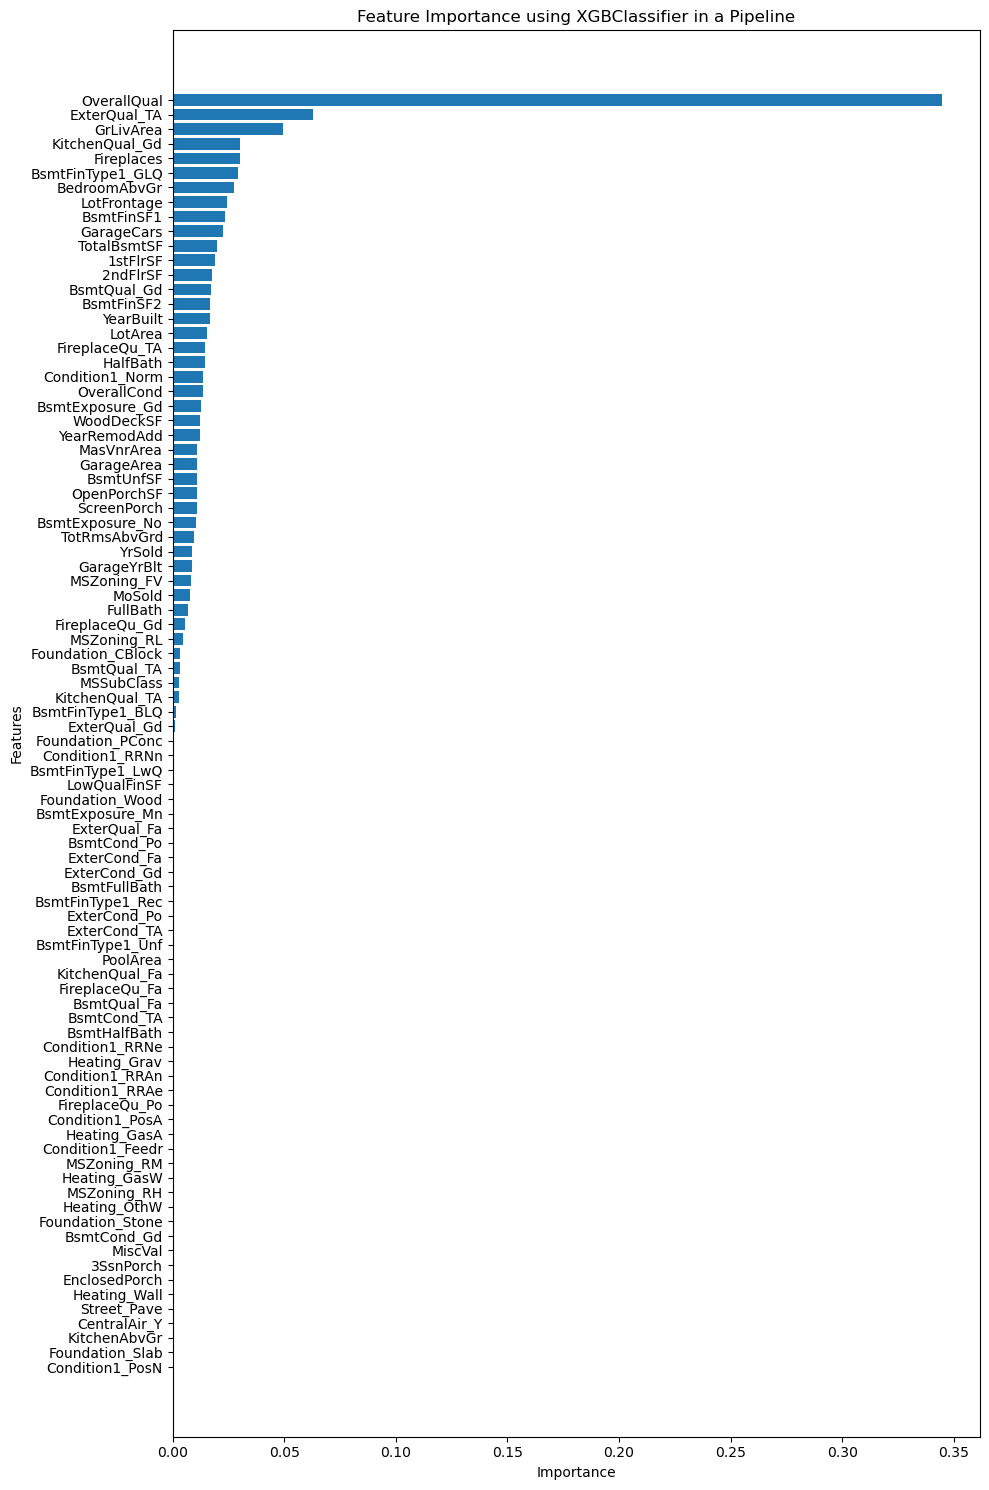

In [69]:
# Sorting the features based on importance
sorted_indices = np.argsort(feature_importances)[::-1]  # [::-1] is used to sort in descending order
sorted_features = [transformed_features[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))  # Adjusted the size for better visibility
plt.barh(sorted_features, sorted_importances)  # Using barh for horizontal bar plot
plt.title("Feature Importance using XGBClassifier in a Pipeline")
plt.ylabel("Features")  # Switched the label as well
plt.xlabel("Importance")
plt.yticks(rotation=0)  # No need to rotate y axis labels
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.tight_layout()
plt.show()

In [70]:
# Get features with importance below 0.01
low_importance_features = [feature for feature, importance in zip(transformed_features, feature_importances) if importance < 0.01]

print(low_importance_features)

['PoolArea', 'MSSubClass', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Street_Pave', 'CentralAir_Y', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'BsmtQual_Fa', 'BsmtQual_TA', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Mn', 'BsmtFinType1_BLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'KitchenQual_Fa', 'KitchenQual_TA', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po']


# Evaluate Model

In [18]:
y_train_pred = model_pipeline.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [19]:
y_test_pred = model_pipeline.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9657534246575342

In [20]:
recall_score(y_test, y_test_pred)

0.8333333333333334

# Refine Model

In [21]:
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "xgbclassifier__learning_rate": [0.01, 0.05, 0.1],
    "xgbclassifier__n_estimators": range(90,110,5),
    "xgbclassifier__max_depth": range(3,10)
    # "xgbclassifier__min_child_weight": [1, 5, 10],
    # "xgbclassifier__gamma": [0.5, 2, 5],
    # "xgbclassifier__subsample": [0.6, 1.0],
    # "xgbclassifier__colsample_bytree": [0.6, 1.0],
    # "xgbclassifier__objective": ['binary:logistic'],
    # "xgbclassifier__eval_metric": ['logloss']
}

In [22]:
recall_scori=make_scorer(recall_score)

In [23]:
search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    verbose=1,
    scoring=recall_scori,
    n_jobs=-2
)

In [25]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'TotalBsmtSF',
                                                                          'BedroomAbvGr',
                                                                          'Fireplaces',
                                                                          'PoolArea',
                                                                          'GarageCars',
                                                                          'WoodDeckSF',
                                                                          'ScreenPorch',
                                                                          'MSSubClass',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'Ma...
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-2,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
                         'xgbclassifier__max_depth': range(3, 10),
                         'xgbclassifier__n_estimators': range(90, 110, 5)},
             scoring=make_scorer(recall_score), verbose=1)

In [26]:
search.best_score_

0.8105169340463456

In [27]:
y_train_pred = search.predict(X_train)

accuracy_score(y_train, y_train_pred)

1.0

In [28]:
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9657534246575342

In [29]:
search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__n_estimators': 100}

In [30]:
recall_score(y_test, y_test_pred)

0.8333333333333334

# Classification performance metrics

## Confusion Matrix

In [31]:
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

In [32]:
cm = confusion_matrix(y_train, y_train_pred)

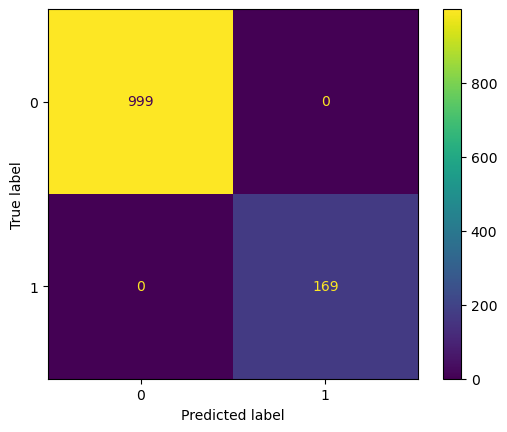

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=search.classes_)
disp.plot()

plt.show()

In [34]:
cm = confusion_matrix(y_test, y_test_pred)

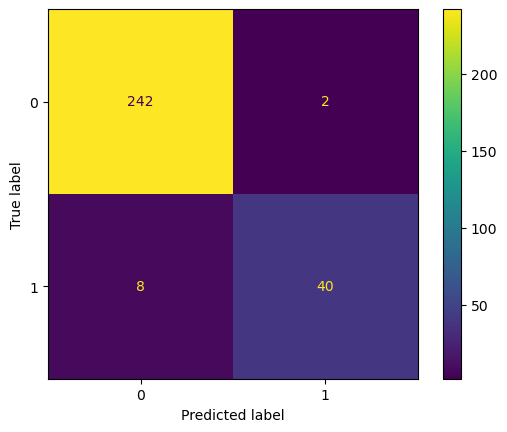

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=search.classes_)
disp.plot()

plt.show()

## Cohen’s Kappa Coefficient

In [41]:
kappa_score = cohen_kappa_score(y_test, y_test_pred)
print(kappa_score)

0.868752247393024
